In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
df = pd.read_csv('/Users/hejielu/Desktop/final/cleandata.csv')
df.head()

,dateoftweet,text
0,06/03/2020,israeli priviledge matt lauer somehow jail bac...
1,06/03/2020,normal viewing documentary netflix essential s...
2,06/03/2020,wish say story need voice suppo metoo
3,06/03/2020,psst saw bit blackout tuesday point previous t...
4,06/03/2020,rivera hus hea see many former female student ...


In [43]:
df.describe()

,dateoftweet,text
count,91653,91653
unique,105,90558
top,06/03/2020,ve now quaratine longer brock turner spent jai...
freq,2546,103


In [8]:
data = df.text.values.tolist()

In [9]:
pprint(data[:1])

['israeli priviledge matt lauer somehow jail back nationally published major '
 'fake news outlet']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['israeli', 'priviledge', 'matt', 'lauer', 'somehow', 'jail', 'back', 'nationally', 'published', 'major', 'fake', 'news', 'outlet']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['israeli', 'priviledge', 'matt_lauer', 'somehow', 'jail', 'back', 'nationally', 'published', 'major', 'fake', 'news', 'outlet']


In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['israeli', 'somehow', 'jail', 'back', 'nationally', 'publish', 'major', 'fake', 'news', 'outlet']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.146*"help" + 0.129*"girl" + 0.116*"experience" + 0.094*"sex" + '
  '0.091*"courage" + 0.070*"other" + 0.049*"remember" + 0.044*"learn" + '
  '0.043*"alone" + 0.027*"include"'),
 (1,
  '0.794*"sexual" + 0.068*"powerful" + 0.034*"rapist" + 0.000*"harassment" + '
  '0.000*"abuse" + 0.000*"make" + 0.000*"change" + 0.000*"never" + '
  '0.000*"child" + 0.000*"late"'),
 (2,
  '0.239*"need" + 0.199*"call" + 0.117*"life" + 0.099*"black" + 0.072*"post" + '
  '0.052*"sorry" + 0.037*"matter" + 0.016*"college" + 0.010*"mention" + '
  '0.008*"argue"'),
 (3,
  '0.260*"assault" + 0.157*"many" + 0.136*"see" + 0.103*"want" + '
  '0.074*"survivor" + 0.064*"female" + 0.046*"voice" + 0.036*"lot" + '
  '0.025*"trauma" + 0.013*"high"'),
 (4,
  '0.529*"story" + 0.095*"world" + 0.090*"back" + 0.051*"away" + 0.048*"live" '
  '+ 0.025*"crime" + 0.021*"account" + 0.015*"release" + 0.000*"harassment" + '
  '0.000*"abuse"'),
 (5,
  '0.722*"metoo" + 0.092*"feel" + 0.066*"still" + 0.038*"find" + 0.014*"act"

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.57900248879541

Coherence Score:  0.22524480000588012


In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.181076  0.330603       1        1  8.165201
5     -0.309830 -0.297876       2        1  7.997461
15    -0.096943  0.056839       3        1  7.427843
19    -0.081156  0.041460       4        1  7.248386
3     -0.088273  0.047992       5        1  6.760926
12    -0.033356  0.011169       6        1  6.585961
9     -0.034041  0.011519       7        1  5.660812
1     -0.007516  0.000654       8        1  5.458621
7      0.042232 -0.013645       9        1  5.359114
18    -0.028052  0.008750      10        1  5.048444
14     0.040240 -0.013159      11        1  4.796774
0      0.035915 -0.012204      12        1  4.228233
10     0.067583 -0.018720      13        1  4.164332
8      0.111224 -0.024622      14        1  3.950949
4      0.043699 -0.013922      15        1  3.784688
17     0.084167 -0.021351      16        1  3.557559
2      0.077248 -0.020284      17        1  3.553567
16     0.095924 -0.022917      18        1  3.466527
6      0.121062 -0.025425      19        1  1.867110
11     0.140948 -0.024862      20        1  0.917489, topic_info=      Category          Freq          Term         Total  loglift  logprob
124    Default  34499.000000         woman  34499.000000  30.0000  30.0000
94     Default  30826.000000         metoo  30826.000000  29.0000  29.0000
32     Default  23150.000000        sexual  23150.000000  28.0000  28.0000
60     Default  14684.000000           man  14684.000000  27.0000  27.0000
20     Default  10701.000000         story  10701.000000  26.0000  26.0000
19     Default  12681.000000           say  12681.000000  25.0000  25.0000
28     Default   9375.000000       assault   9375.000000  24.0000  24.0000
140    Default   8269.000000          know   8269.000000  23.0000  23.0000
105    Default   7075.000000            go   7075.000000  22.0000  22.0000
27     Default   7416.000000          time   7416.000000  21.0000  21.0000
113    Default   5602.000000          rape   5602.000000  20.0000  20.0000
179    Default   7515.000000          year   7515.000000  19.0000  19.0000
10     Default   8610.000000            be   8610.000000  18.0000  18.0000
68     Default   7948.000000        people   7948.000000  17.0000  17.0000
236    Default   6849.000000         think   6849.000000  16.0000  16.0000
47     Default   5429.000000          come   5429.000000  15.0000  15.0000
76     Default   6050.000000         share   6050.000000  14.0000  14.0000
95     Default   7202.000000         thank   7202.000000  13.0000  13.0000
229    Default   5928.000000        victim   5928.000000  12.0000  12.0000
33     Default   7001.000000         speak   7001.000000  11.0000  11.0000
85     Default   6460.000000          take   6460.000000  10.0000  10.0000
43     Default   4956.000000      movement   4956.000000   9.0000   9.0000
31     Default   5670.000000          many   5670.000000   8.0000   8.0000
235    Default   5570.000000          tell   5570.000000   7.0000   7.0000
18     Default   4530.000000          need   4530.000000   6.0000   6.0000
26     Default   4897.000000           see   4897.000000   5.0000   5.0000
96     Default   4044.000000          even   4044.000000   4.0000   4.0000
87     Default   3774.000000          call   3774.000000   3.0000   3.0000
195    Default   4293.000000          work   4293.000000   2.0000   2.0000
55     Default   3587.000000         thing   3587.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
26182  Topic20      0.081502      redlight      2.242444   1.3766 -11.0043
766    Topic20      0.081501   embarrassed      2.242441   1.3766 -11.0043
383    Topic20      0.081502         grace      2.242457   1.3766 -11.0043
19603  Topic20      0.081501          pedo      2.242437   1.3766 -11.0043
10081  Topic20      0.081501          mute      2.242447   1.3766 -11.0043
16542  Topic20  

In [31]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/hejielu/Desktop//mallet-2.0.8/bin/mallet' # update this path

In [32]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('abuse', 0.12708793636765356),
   ('rape', 0.1137870083959346),
   ('sex', 0.05307114449845338),
   ('child', 0.04122845779938135),
   ('victim', 0.036367653557224926),
   ('case', 0.025011047282368536),
   ('sexually', 0.020150243040212106),
   ('rapist', 0.015554573574900574),
   ('accuse', 0.015466195315952275),
   ('family', 0.01444984533804684)]),
 (1,
  [('metoo', 0.06798145960192675),
   ('give', 0.06207397982368445),
   ('people', 0.057620648913932565),
   ('put', 0.03444515132236663),
   ('point', 0.028446787239843677),
   ('wrong', 0.024266109242933747),
   ('find', 0.022811960374443333),
   ('hard', 0.021403253658093247),
   ('hand', 0.01804053439970917),
   ('sad', 0.015086794510588022)]),
 (18,
  [('movement', 0.06108945889603915),
   ('change', 0.0609081845372972),
   ('power', 0.04386839481555334),
   ('end', 0.03371703072600381),
   ('culture', 0.030680685217076044),
   ('feminist', 0.030635366627390557),
   ('continue', 0.02320311791897036),
   ('create', 0.02

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

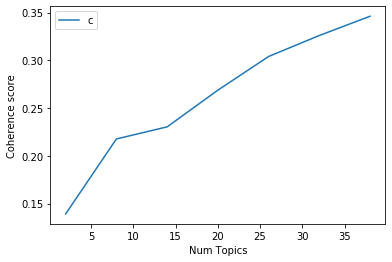

In [36]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1392
Num Topics = 8  has Coherence Value of 0.2177
Num Topics = 14  has Coherence Value of 0.2303
Num Topics = 20  has Coherence Value of 0.2687
Num Topics = 26  has Coherence Value of 0.304
Num Topics = 32  has Coherence Value of 0.326
Num Topics = 38  has Coherence Value of 0.3461


In [39]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.130*"abuse" + 0.044*"power" + 0.044*"survivor" + 0.042*"child" + '
  '0.038*"violence" + 0.034*"end" + 0.029*"face" + 0.025*"give" + '
  '0.021*"sexually" + 0.019*"woman"'),
 (1,
  '0.080*"today" + 0.048*"watch" + 0.034*"join" + 0.032*"call" + 0.031*"day" + '
  '0.022*"fire" + 0.021*"week" + 0.020*"resign" + 0.019*"tonight" + '
  '0.019*"video"'),
 (2,
  '0.191*"woman" + 0.077*"movement" + 0.062*"work" + 0.041*"black" + '
  '0.036*"give" + 0.036*"turn" + 0.029*"ago" + 0.027*"post" + 0.023*"industry" '
  '+ 0.023*"create"'),
 (3,
  '0.065*"metoo" + 0.044*"female" + 0.037*"male" + 0.035*"caign" + '
  '0.027*"include" + 0.021*"question" + 0.020*"lead" + 0.019*"light" + '
  '0.017*"sign" + 0.016*"response"'),
 (4,
  '0.266*"man" + 0.254*"woman" + 0.025*"put" + 0.023*"white" + '
  '0.016*"powerful" + 0.016*"harass" + 0.016*"behavior" + 0.015*"hate" + '
  '0.010*"bully" + 0.009*"afraid"'),
 (5,
  '0.062*"change" + 0.059*"movement" + 0.049*"call" + 0.031*"culture" + '
  '0.025*"hold

In [40]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.1102,"metoo, late, news, listen, check, daily, women...",israeli priviledge matt lauer somehow jail bac...
1,1,9.0,0.0692,"rape, victim, sex, claim, case, rapist, blame,...",normal viewing documentary netflix essential s...
2,2,17.0,0.0694,"story, share, experience, metoo, learn, world,...",wish say story need voice suppo metoo
3,3,18.0,0.0717,"people, show, talk, love, life, problem, movem...",psst saw bit blackout tuesday point previous t...
4,4,19.0,0.0804,"sexual, harassment, assault, accuse, allegatio...",rivera hus hea see many former female student ...
5,5,8.0,0.0730,"metoo, hope, suppo, tweet, find, vote, resist,...",uh dont feel ashamed still shameful act
6,6,0.0,0.0500,"abuse, power, survivor, child, violence, end, ...",metoo
7,7,18.0,0.0677,"people, show, talk, love, life, problem, movem...",see parallel metoo movement suppo tara reade g...
8,8,11.0,0.0789,"metoo, late, news, listen, check, daily, women...",s fair question first thing d say dynamic soci...
9,9,4.0,0.0833,"man, woman, put, white, powerful, harass, beha...",lmaoo laughable seen powerful men essentially ...


In [41]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1750,"abuse, power, survivor, child, violence, end, ...",please help u suppo yihwakim domestic sexual v...
1,1.0,0.1772,"today, watch, join, call, day, fire, week, res...",trailer bodak yellow remix watch music video t...
2,2.0,0.1532,"woman, movement, work, black, give, turn, ago,...",thalapathy recent function black dress black o...
3,3.0,0.1721,"metoo, female, male, caign, include, question,...",french food exists french cheese exists french...
4,4.0,0.1509,"man, woman, put, white, powerful, harass, beha...",men harass use porn men use porn harass men ha...


In [42]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,11.0,"metoo, late, news, listen, check, daily, women...",9308.0,0.1016
1,9.0,"rape, victim, sex, claim, case, rapist, blame,...",5627.0,0.0614
2,17.0,"story, share, experience, metoo, learn, world,...",4389.0,0.0479
3,18.0,"people, show, talk, love, life, problem, movem...",5084.0,0.0555
4,19.0,"sexual, harassment, assault, accuse, allegatio...",4533.0,0.0495
5,8.0,"metoo, hope, suppo, tweet, find, vote, resist,...",4325.0,0.0472
6,0.0,"abuse, power, survivor, child, violence, end, ...",4672.0,0.0510
7,18.0,"people, show, talk, love, life, problem, movem...",4465.0,0.0487
8,11.0,"metoo, late, news, listen, check, daily, women...",4212.0,0.0460
9,4.0,"man, woman, put, white, powerful, harass, beha...",4401.0,0.0480
